# State-level Covid-19 Analysis for United States

This notebook utilizes data kindly made available by the Johns Hopkins University System Group at 
https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series.

It provides a temporal perspective that complements their excellent geospatial presentation.  

The thing about exponentials with a measurable daily growth rate is they change so fast.  With cases increasing 25% per day,a week means a factor of 5 and a month a factor of a thousand.


* Repo for this and other notebnooks at: [https://github.com/deculler/covid19](https://github.com/deculler/covid19)
* Website for this repo: [https://deculler.github.io/covid19/](https://deculler.github.io/covid19/)

## View and run the notebooks

* [View the notebook with nbviewer](https://nbviewer.jupyter.org/github/deculler/covid19/blob/master/US-covid19-nytimes.ipynb)
* [Launch it on mybinder.org](https://mybinder.org/v2/gh/deculler/covid19/master?filepath=work/US-covid19-nytimes.ipynb)
* [@UCB on datahub.berkeley.edu](http://datahub.berkeley.edu/user-redirect/interact?account=deculler&repo=covid19&branch=master&path=US-covid19-nytimes.ipynb)
  
## Quick links to sections

* [Cases by state](#sectionCases)
* [Deaths by state](#sectionDeaths)
* [Growth trends by state](#sectionGrowth)
* [Cases one state](#sectionOneState)
* [Projection of cases in one state](#sectionProj)
* [Projection of deaths in one state](#sectionProjDeath)

The dataset only contains confirmed cases and death, not recoveries.  The data on recoveries tends not to be very good anyways, because case tracking is so poor.  But more importantly, the level of penetration of the virus is still in such an early stage that the eventual balancing out in the SIR models is irrelevant.  With infections growing at 15% per day, if all of today's cases recovered two weeks out, it would only be 1/16th of the new cases.  We are looking at days and weeks, not months and years.

For dataframes it uses Datascience Tables (for reference see http://data8.org/datascience/tables.html) developed for introductory courses as UCB.

In [1]:
# A week, A month, two weeks out ...
1.25**7, 1.25**31, 1.15*14

(4.76837158203125, 1009.7419586828951, 16.099999999999998)

In [2]:
# HIDDEN
# This useful nonsense should just go at the top of your notebook.
from datascience import *
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plots
import numpy as np
import scipy
plots.style.use('fivethirtyeight')
plots.rc('lines', linewidth=2, color='r')
from ipywidgets import interact
import ipywidgets as widgets
# datascience version number of last run of this notebook
version.__version__

'0.15.0'

In [3]:
import sys
sys.path.append(".")
from timetable import TimeTable

import locale
locale.setlocale( locale.LC_ALL, 'en_US.UTF-8' ) 

import os
import datetime

# Tools for working with timestamps
day_fmt = "%Y-%m-%d"

def less_day(day1, day2):
    """Return day1 < day2"""
    return datetime.datetime.strptime(day1, day_fmt) < datetime.datetime.strptime(day2, day_fmt)

def format_day(day):
    """Return day """
    date =  datetime.datetime.strptime(day, day_fmt)
    return datetime.datetime.strftime(date, day_fmt)

def inc_day(day, ndays=1):
    """Return day + ndays"""
    date =  datetime.datetime.strptime(day, day_fmt) + datetime.timedelta(days=ndays)
    return datetime.datetime.strftime(date, day_fmt)

def ave_growth(trend, window=4):
    """Average recent growth rate of single trend"""
    vals = [x for x in trend.take[-window:]['rate'] if np.isfinite(x)]
    return scipy.stats.gmean(vals)


def project_trend(trend, num_days, rate=None, window=4):
    if rate :
        growth_rate = rate
    else :
        growth_rate = ave_growth(trend, window)
        
    day = trend.last('date')
    val = trend.last(1)
    growth = trend.last('new')
    pnew = trend.last('% new')
    proj = trend.copy()
    for i in range(num_days):
        day = inc_day(day)
        growth = round(growth * growth_rate)
        val = val + growth
        pnew = growth/val
        proj.append((day, val, growth, pnew, growth_rate))
    return proj

In [4]:
# Tools specific to the notebook analysis

def prior_to(self, prev, time_end=None):
    """Return TimeTable of prev rows prior to time_end, defaults to last."""
    if not time_end :
        time_end = self.last(self.time_column)
    elif isinstance(time_end, int):
        time_end = inc_day(self.last(self.time_column), -time_end)
    return self.between(inc_day(time_end, -prev), time_end)

def make_pname(root, prev):
    return root + "-" + str(prev)

def proj_timeseries(ts, region, dist=14, end=None):
    if not end:
        end = ts['date'][-1]
    return project_trend(ts.extract(region).trend(), dist).select(['date', region, 'new'])

def proj2_timeseries(ts, region, prev=2, dist=14, end=None,):
    if not end:
        end = ts['date'][-1]
    proj  = project_trend(prior_to(ts.extract(region), 7+prev ).trend(), dist).select(['date', region, 'new'])
    proj1 = project_trend(prior_to(ts.extract(region), 7, prev).trend(), dist+prev).select(['date', region, 'new'])
    proj1.relabel(region, make_pname(region, prev))
    proj1.relabel('new',  make_pname('new', prev))
    combined = TimeTable.from_table(proj.join('date', proj1), time_col = 'date')
    return combined

def proj(ts, region, prev=7, dist=14, end=None):
    if not end:
        end = ts['date'][-1]
    proj = proj_timeseries(ts, region, dist, end)
    prior_to(proj, dist).show()
    prior_to(proj.select(['date', region, 'new']), prev+dist).plot('date', width = 7)
    plots.plot([end, end], [0, ts[region][-1]])
    _ = plots.xticks(rotation=90)
    
def proj2(ts, region, prev=2, dist=14, end=None):
    if not end:
        end = ts['date'][-1]
    pend = inc_day(end, -prev)
    combined = proj2_timeseries(ts, region, prev, dist, end)
    combined.oplot(height=6, width=6)
    plots.plot([end, end], [0, combined[region][-1]])
    plots.plot([pend, pend], [0, combined[make_pname(region, prev)][-1]])
    _ = plots.xticks(rotation=90)
    
def get_rates(ts):
    trends = ts.trend()
    rates = trends.extract([x for x in trends.labels if 'rate' in x])
    for label in rates.categories :
        rates.relabel(label, label[5:])
    return rates

In [5]:
#URL for https://github.com/nytimes/covid-19-data/blob/master/us-states.csv

stateURL = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv"

In [6]:
raw_states = Table.read_table(stateURL)
states = list(np.unique(raw_states['state']))
len(states)

55

In [7]:
cases = TimeTable.from_table(raw_states.pivot('state', 'date', 'cases', sum), time_col = 'date', 
                             time_less_fun=less_day)
deaths = TimeTable.from_table(raw_states.pivot('state', 'date', 'deaths', sum), time_col = 'date',
                             time_less_fun=less_day)

In [8]:
last_day = cases['date'][-1]
last_day

'2020-04-05'

## US National picture

Until [shjelter at home measures finally began to go in place](https://www.nytimes.com/interactive/2020/us/coronavirus-stay-at-home-order.html) - March 19 for California (March 17 for 6 of its counties) the daily growth rate climbing towards 50% new cases per day.  Since that time it has been dropping towards 17% per day.  While still way to fast for the health care systems to manage, it the difference is immense.  Cases grow by an order of magnitude over two weeks, instead of one,

Current US Cases 336776


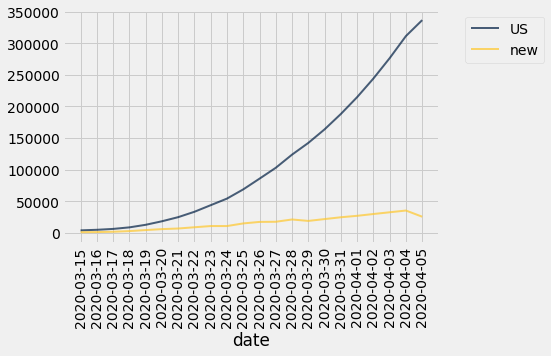

In [9]:
US_cases = cases.select(cases.time_column)
US_cases['US'] = cases.sum_cols()
print('Current US Cases', US_cases['US'][-1])
US_case_trend = US_cases.trend()
prior_to(US_case_trend.extract(['US', 'new']), 21).oplot()
_ = plots.xticks(rotation=90)

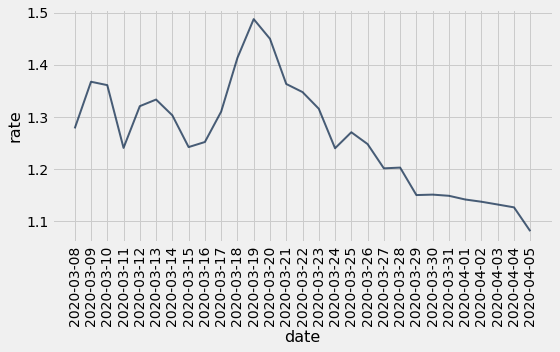

In [10]:
prior_to(US_case_trend.extract(['rate']), 28).oplot(width=8)
_ = plots.xticks(rotation=90)

<a id=sectionCases></a>
## Cases to date by state

The following shows the national picture built up state by state.  Only the largest are shown, with the remainder
grouped into 'other'.

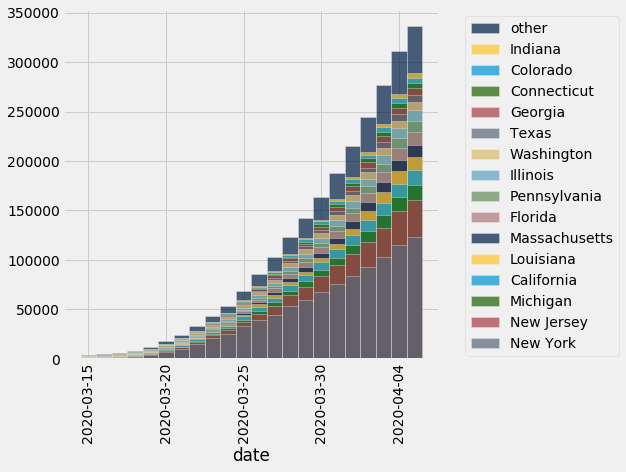

In [11]:
# Total US cases broken down by state
cases.following("2020-03-15").stackbar(15, height=6)
_ = plots.xticks(rotation=90)

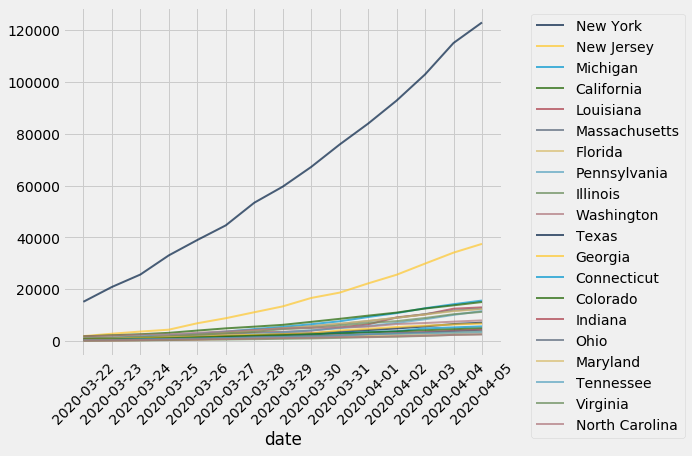

In [12]:
# Cases by state over the past two weeks
prior_to(cases.top(20), 14).plot('date', width=7, height=6)
_ = plots.xticks(rotation=45)

In [13]:
def cases_since(cases, threshold=100, width=6, height=6):
    _, axis = plots.subplots(figsize=(width, height))
    for region in cases.categories :
        ctbl = cases.extract(region)
        since = ctbl.where(ctbl[region] >= threshold)
        ndays = since.num_rows
        vals = since[region]
        axis.plot(vals)
        axis.text(ndays-1, vals[-1], region)

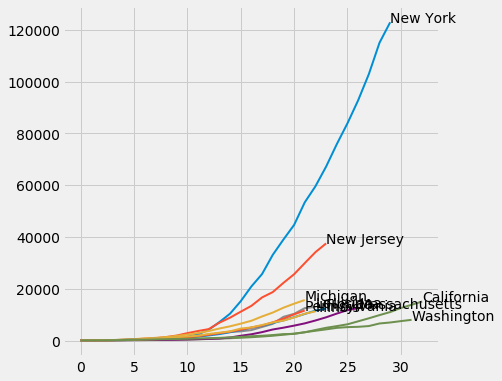

In [14]:
cases_since(cases.top(10), 50)

<a id='sectionTrends'></a>
## Growth trends by state

An important caveat is that the dirth of testing makes the number of report cases, and particularly the change in that number, messy.  Increased test coverage will tend to increase the number of confirmed cases, whereas containment and mitigation measures may actually be reducing the spread.

The `% new` columns simply look at what fraction of a day's cases are newly reported in that day.  The `rate` columns take the geometric mean of ratio of successive days over a window of the past few days. This provides a little smoothing, but it does not try to project changes in rate.  That is reflected in the series of rates.  Modulo the testing factors, this provides some indication of where measures are working or not.

Death rates are relatively insensitive to the testing error, but are such a lagging indicator they have a limited role in setting expectations for case loads.

In [15]:
prior_to(cases.order_cols().trend(), 7)

date,New York,new New York,% newNew York,rate New York,New Jersey,new New Jersey,% newNew Jersey,rate New Jersey,Michigan,new Michigan,% newMichigan,rate Michigan,California,new California,% newCalifornia,rate California,Louisiana,new Louisiana,% newLouisiana,rate Louisiana,Massachusetts,new Massachusetts,% newMassachusetts,rate Massachusetts,Florida,new Florida,% newFlorida,rate Florida,Pennsylvania,new Pennsylvania,% newPennsylvania,rate Pennsylvania,Illinois,new Illinois,% newIllinois,rate Illinois,Washington,new Washington,% newWashington,rate Washington,Texas,new Texas,% newTexas,rate Texas,Georgia,new Georgia,% newGeorgia,rate Georgia,Connecticut,new Connecticut,% newConnecticut,rate Connecticut,Colorado,new Colorado,% newColorado,rate Colorado,Indiana,new Indiana,% newIndiana,rate Indiana,Ohio,new Ohio,% newOhio,rate Ohio,Maryland,new Maryland,% newMaryland,rate Maryland,Tennessee,new Tennessee,% newTennessee,rate Tennessee,Virginia,new Virginia,% newVirginia,rate Virginia,North Carolina,new North Carolina,% newNorth Carolina,rate North Carolina,Missouri,new Missouri,% newMissouri,rate Missouri,Arizona,new Arizona,% newArizona,rate Arizona,Wisconsin,new Wisconsin,% newWisconsin,rate Wisconsin,South Carolina,new South Carolina,% newSouth Carolina,rate South Carolina,Nevada,new Nevada,% newNevada,rate Nevada,Alabama,new Alabama,% newAlabama,rate Alabama,Mississippi,new Mississippi,% newMississippi,rate Mississippi,Utah,new Utah,% newUtah,rate Utah,Oklahoma,new Oklahoma,% newOklahoma,rate Oklahoma,Idaho,new Idaho,% newIdaho,rate Idaho,Oregon,new Oregon,% newOregon,rate Oregon,Kentucky,new Kentucky,% newKentucky,rate Kentucky,District of Columbia,new District of Columbia,% newDistrict of Columbia,rate District of Columbia,Minnesota,new Minnesota,% newMinnesota,rate Minnesota,Rhode Island,new Rhode Island,% newRhode Island,rate Rhode Island,Iowa,new Iowa,% newIowa,rate Iowa,Arkansas,new Arkansas,% newArkansas,rate Arkansas,Kansas,new Kansas,% newKansas,rate Kansas,Delaware,new Delaware,% newDelaware,rate Delaware,New Hampshire,new New Hampshire,% newNew Hampshire,rate New Hampshire,New Mexico,new New Mexico,% newNew Mexico,rate New Mexico,Vermont,new Vermont,% newVermont,rate Vermont,Puerto Rico,new Puerto Rico,% newPuerto Rico,rate Puerto Rico,Maine,new Maine,% newMaine,rate Maine,Nebraska,new Nebraska,% newNebraska,rate Nebraska,Hawaii,new Hawaii,% newHawaii,rate Hawaii,West Virginia,new West Virginia,% newWest Virginia,rate West Virginia,Montana,new Montana,% newMontana,rate Montana,Guam,new Guam,% newGuam,rate Guam,South Dakota,new South Dakota,% newSouth Dakota,rate South Dakota,North Dakota,new North Dakota,% newNorth Dakota,rate North Dakota,Wyoming,new Wyoming,% newWyoming,rate Wyoming,Alaska,new Alaska,% newAlaska,rate Alaska,Virgin Islands,new Virgin Islands,% newVirgin Islands,rate Virgin Islands,Northern Mariana Islands,new Northern Mariana Islands,% newNorthern Mariana Islands,rate Northern Mariana Islands
2020-03-29,59568,6205,0.104167,1.11628,13386,2262,0.168983,1.20334,5486,851,0.155122,1.1836,6266,701,0.111874,1.12597,3540,225,0.0635593,1.06787,4955,698,0.140868,1.16397,4942,904,0.182922,1.22387,3441,626,0.181924,1.22238,4613,1066,0.231086,1.30054,4896,585,0.119485,1.1357,2712,551,0.203171,1.25497,2683,236,0.0879612,1.09644,1993,469,0.235324,1.30774,2315,254,0.109719,1.12324,1514,282,0.186262,1.2289,1665,259,0.155556,1.18421,1244,178,0.143087,1.16698,1570,206,0.13121,1.15103,890,150,0.168539,1.2027,1167,195,0.167095,1.20062,903,65,0.0719823,1.07757,929,156,0.167922,1.20181,1120,78,0.0696429,1.07486,774,114,0.147287,1.17273,920,182,0.197826,1.24661,830,110,0.13253,1.15278,759,90,0.118577,1.13453,719,111,0.154381,1.18257,429,52,0.121212,1.13793,310,49,0.158065,1.18774,548,69,0.125912,1.14405,439,45,0.102506,1.11421,342,0,0,1,504,63,0.125,1.14286,294,55,0.187075,1.23013,336,38,0.113095,1.12752,449,40,0.0890869,1.0978,332,61,0.183735,1.22509,232,18,0.0775862,1.08411,258,44,0.170543,1.20561,237,29,0.122363,1.1394

In [16]:
def rate_change(ts, region_type, prev=7):
    rates = get_rates(ts)
    regions = ts.categories
    current = rates.row(-1)[1:]
    older = rates.row(-1-prev)[1:]
    return Table().with_columns(region_type, regions,
                                'rate', current, 
                                make_pname('rate', prev), older)

def show_rate_change(ts, region_type, prev=7):
    rc = rate_change(ts, region_type, prev)
    rc.drop(0).scatter('rate')
    plots.plot([ min(rc['rate']), max(rc['rate']) ], [ min(rc['rate']), max(rc['rate']) ])

The interactive chart below shows for each state the current growth rate (horizontal) versus the growth rate some days previous.  The distance able the line shows how much the growth rate has improved, below the line the growth rate is getting worse.  Gives a sense of how the measures are working.

In [17]:
def irate(previous=7):
    show_rate_change(cases, 'State', previous)

_ = interact(irate, previous = (1,28,1))

interactive(children=(IntSlider(value=7, description='previous', max=28, min=1), Output()), _dom_classes=('wid…

<a id=sectionDeaths></a>
## Deaths to date by state

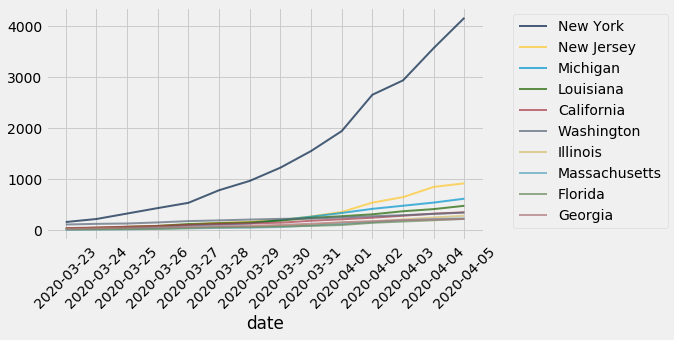

In [18]:
deaths.top(10).take[-14:].plot('date', width=7)
_ = plots.xticks(rotation=45)

In [19]:
prior_to(deaths.order_cols().trend(), 7)

date,New York,new New York,% newNew York,rate New York,New Jersey,new New Jersey,% newNew Jersey,rate New Jersey,Michigan,new Michigan,% newMichigan,rate Michigan,Louisiana,new Louisiana,% newLouisiana,rate Louisiana,California,new California,% newCalifornia,rate California,Washington,new Washington,% newWashington,rate Washington,Illinois,new Illinois,% newIllinois,rate Illinois,Massachusetts,new Massachusetts,% newMassachusetts,rate Massachusetts,Florida,new Florida,% newFlorida,rate Florida,Georgia,new Georgia,% newGeorgia,rate Georgia,Connecticut,new Connecticut,% newConnecticut,rate Connecticut,Pennsylvania,new Pennsylvania,% newPennsylvania,rate Pennsylvania,Colorado,new Colorado,% newColorado,rate Colorado,Texas,new Texas,% newTexas,rate Texas,Indiana,new Indiana,% newIndiana,rate Indiana,Ohio,new Ohio,% newOhio,rate Ohio,Wisconsin,new Wisconsin,% newWisconsin,rate Wisconsin,Maryland,new Maryland,% newMaryland,rate Maryland,Arizona,new Arizona,% newArizona,rate Arizona,Missouri,new Missouri,% newMissouri,rate Missouri,Virginia,new Virginia,% newVirginia,rate Virginia,Tennessee,new Tennessee,% newTennessee,rate Tennessee,Nevada,new Nevada,% newNevada,rate Nevada,Oklahoma,new Oklahoma,% newOklahoma,rate Oklahoma,Alabama,new Alabama,% newAlabama,rate Alabama,Kentucky,new Kentucky,% newKentucky,rate Kentucky,South Carolina,new South Carolina,% newSouth Carolina,rate South Carolina,Mississippi,new Mississippi,% newMississippi,rate Mississippi,North Carolina,new North Carolina,% newNorth Carolina,rate North Carolina,Minnesota,new Minnesota,% newMinnesota,rate Minnesota,Oregon,new Oregon,% newOregon,rate Oregon,Rhode Island,new Rhode Island,% newRhode Island,rate Rhode Island,Kansas,new Kansas,% newKansas,rate Kansas,District of Columbia,new District of Columbia,% newDistrict of Columbia,rate District of Columbia,Iowa,new Iowa,% newIowa,rate Iowa,Vermont,new Vermont,% newVermont,rate Vermont,Puerto Rico,new Puerto Rico,% newPuerto Rico,rate Puerto Rico,Arkansas,new Arkansas,% newArkansas,rate Arkansas,Delaware,new Delaware,% newDelaware,rate Delaware,New Mexico,new New Mexico,% newNew Mexico,rate New Mexico,Idaho,new Idaho,% newIdaho,rate Idaho,Maine,new Maine,% newMaine,rate Maine,New Hampshire,new New Hampshire,% newNew Hampshire,rate New Hampshire,Nebraska,new Nebraska,% newNebraska,rate Nebraska,Utah,new Utah,% newUtah,rate Utah,Montana,new Montana,% newMontana,rate Montana,Alaska,new Alaska,% newAlaska,rate Alaska,Guam,new Guam,% newGuam,rate Guam,Hawaii,new Hawaii,% newHawaii,rate Hawaii,North Dakota,new North Dakota,% newNorth Dakota,rate North Dakota,West Virginia,new West Virginia,% newWest Virginia,rate West Virginia,South Dakota,new South Dakota,% newSouth Dakota,rate South Dakota,Northern Mariana Islands,new Northern Mariana Islands,% newNorthern Mariana Islands,rate Northern Mariana Islands,Virgin Islands,new Virgin Islands,% newVirgin Islands,rate Virgin Islands,Wyoming,new Wyoming,% newWyoming,rate Wyoming
2020-03-29,965,183,0.189637,1.23402,161,21,0.130435,1.15,132,21,0.159091,1.18919,152,15,0.0986842,1.10949,130,9,0.0692308,1.07438,207,16,0.0772947,1.08377,70,20,0.285714,1.4,48,4,0.0833333,1.09091,59,3,0.0508475,1.05357,83,4,0.0481928,1.05063,34,1,0.0294118,1.0303,40,5,0.125,1.14286,47,3,0.0638298,1.06818,35,6,0.171429,1.2069,32,1,0.03125,1.03226,30,5,0.166667,1.2,17,0,0,1,11,1,0.0909091,1.1,18,3,0.166667,1.2,12,2,0.166667,1.2,22,5,0.227273,1.29412,7,1,0.142857,1.16667,15,1,0.0666667,1.07143,16,1,0.0625,1.06667,5,1,0.2,1.25,9,0,0,1,16,1,0.0625,1.06667,14,1,0.0714286,1.07692,6,2,0.333333,1.5,9,4,0.444444,1.8,13,0,0,1,3,1,0.333333,1.5,7,1,0.142857,1.16667,4,0,0,1,4,1,0.25,1.33333,12,0,0,1,5,2,0.4,1.66667,6,1,0.166667,1.2,6,1,0.166667,1.2,2,0,0,1,6,1,0.166667,1.2,3,2,0.666667,3,3,1,0.333333,1.5,2,0,0,1,2,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,0,0,nan,nan,1,0,0,1,1,1,1,inf,1,0,0,1,0,0,nan,nan,0,0,nan,nan,0,0,nan,nan
2020-03-30,1224,259,0.211601,1.26839,199,38,0.190955,1.23602,197,65,0.329949,1.49242,186,34,0.182796,1.22368

<a id='sectionOneState'></a>
## Cases in one state

These sections of the notebook allow diving into the picture for a particular state.  We start with the basic trends and then look at projects up to a couple weeks out.  Things are changing so rapidly, it is pretty meaningless to talk about numbers farther out than that.  Whereas just looking at the short term puts in stark relief how rapidly we need to move in preparing to care for infected people.

In [20]:
def show_st(state='California', prev = 7):
    prior_to(cases.extract(state).trend(), prev).show()
    prior_to(cases.extract(state).trend().extract([state, 'new']), 21).plot('date', width=7)
    _ = plots.xticks(rotation=90)
    prior_to(cases.extract(state).trend().extract(['rate']), 21).plot('date', width=7)
    _ = plots.xticks(rotation=90)

_ = interact(show_st, state=states, prev = (7, 21, 1))

interactive(children=(Dropdown(description='state', index=4, options=('Alabama', 'Alaska', 'Arizona', 'Arkansa…

<a id='sectionProj'></a>
## Projection of cases in one state

To look forward at what the story may be over the coming days, we project forward the recent growth rate.  This may be pessimistic if measures are working and the rate is improving.  But, the rate of change in the rate is low enough and the variability due to external factors high enough that any more sophisticated method seems dubious.

The vertical line shows where we are today.

In [21]:
def proj_st(state='California', dist=14):
    proj(cases, state, 7, dist)
    
_ = interact(proj_st, state=states, dist = (7, 14, 1))

interactive(children=(Dropdown(description='state', index=4, options=('Alabama', 'Alaska', 'Arizona', 'Arkansa…

<a id='sectionProjDeath'></a>
## Projection of deaths in one state

In [22]:
def proj_st_deaths(state='California', dist=14):
    proj(deaths, state, 7, dist)

_ = interact(proj_st_deaths, state=states, dist = (7, 14, 1))

interactive(children=(Dropdown(description='state', index=4, options=('Alabama', 'Alaska', 'Arizona', 'Arkansa…

## Are the projections changing with mitigation measures?

We are seeing reductions in growth rates as communities adopt shelter in place and other isolation measures.  How does out prediction today for two weeks out differ from what we would have made yesterday for 15 days out?  

This graph shows the project based on the most current data and compares it to the projection based on
`prev` days ago.  If measures are succeeding, we should see improvements relative to `-prev`.  The distance of projection is adjustable.

In [23]:
def proj2_st(state='California', prev=2, dist=14):
    proj2(cases, state, prev, dist)
    
_ = interact(proj2_st, state=states, prev=(0,7,1), dist=(3, 14, 1))

interactive(children=(Dropdown(description='state', index=4, options=('Alabama', 'Alaska', 'Arizona', 'Arkansa…

In [24]:
def proj2_st_deaths(state='California', prev=2):
    proj2(deaths, state, prev)
    
_ = interact(proj2_st_deaths, state=states, prev=(0,7,1))

interactive(children=(Dropdown(description='state', index=4, options=('Alabama', 'Alaska', 'Arizona', 'Arkansa…

## Changes in case rates

Here we try to get a handle on the spread of rates and whether they are improving.

In [25]:
prior_to(get_rates(cases), 7)

date,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,Georgia,Guam,Hawaii,Idaho,Illinois,Indiana,Iowa,Kansas,Kentucky,Louisiana,Maine,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,New Hampshire,New Jersey,New Mexico,New York,North Carolina,North Dakota,Northern Mariana Islands,Ohio,Oklahoma,Oregon,Pennsylvania,Puerto Rico,Rhode Island,South Carolina,South Dakota,Tennessee,Texas,Utah,Vermont,Virgin Islands,Virginia,Washington,West Virginia,Wisconsin,Wyoming
2020-03-29,1.15278,1.11765,1.20181,1.0978,1.12597,1.12324,1.30774,1.08411,1,1.22387,1.09644,1.01754,1.15894,1.18774,1.30054,1.2289,1.12752,1.22509,1.11421,1.06787,1.19905,1.16698,1.16397,1.1836,1.14286,1.13453,1.07757,1.09524,1.12295,1.24661,1.20561,1.20334,1.13942,1.11628,1.20062,1.04255,1,1.18421,1.13793,1.14405,1.22238,1.27,1.23013,1.17273,1.32353,1.15103,1.25497,1.18257,1.11374,1.21053,1.2027,1.1357,1.09735,1.07486,1.03571
2020-03-30,1.14096,1.04386,1.25834,1.1314,1.18433,1.13521,1.29002,1.13793,1.44737,1.15217,1.13008,1.03448,1.16571,1.33871,1.09907,1.18098,1.2619,1.12349,1.09339,1.13701,1.08696,1.13666,1.16085,1.18629,1.14286,1.11726,1.16279,1.09938,1.35036,1.13478,1.21705,1.24279,1.18565,1.12769,1.1174,1.11224,1,1.16096,1.12121,1.10584,1.20779,1.37008,1.38776,1.19509,1.12222,1.09618,1.12205,1.121,1.08936,1.30435,1.14719,1.0578,1.16935,1.13125,1.09195
2020-03-31,1.05491,1.11765,1.11035,1.11024,1.15645,1.13775,1.21665,1.20833,1,1.18388,1.35785,2.31667,1.09804,1.26747,1.18225,1.20749,1.17453,1.16354,1.22917,1.30112,1.10182,1.17539,1.1509,1.1724,1.09201,1.10495,1.28667,1.11864,1.04324,1.06609,1.16879,1.12383,1.121,1.12889,1.17178,1.15596,1,1.13761,1.17672,1.13861,1.20236,1.37356,1.19608,1.17081,1.06931,1.19059,1.17516,1.1005,1.14453,1,1.22429,1.02182,1.11724,1.0663,1.26316
2020-04-01,1.10711,1.07519,1.0886,1.10638,1.14379,1.11906,1.13715,1.15361,1.18384,1.15191,1.15327,1.05755,1.15179,1.27186,1.1645,1.18805,1.10241,1.12442,1.15593,1.22666,1.13531,1.19434,1.16888,1.21796,1.09539,1.14514,1.17024,1.09596,1.29016,1.14915,1.13079,1.19036,1.15238,1.10625,1.03534,1.16667,3,1.15825,1.27032,1.06667,1.1617,1.19665,1.15984,1.19391,1.19444,1.31284,1.19155,1.14092,1.09556,1,1.2088,1.05593,1.17901,1.1473,1.14167
2020-04-02,1.14828,1.02098,1.13234,1.09455,1.12011,1.11417,1.07506,1.06793,1.11433,1.15905,1.14659,1.03401,1.0969,1.33184,1.10244,1.1848,1.1184,1.13525,1.10704,1.42435,1.09302,1.17431,1.1587,1.1612,1.07692,1.09692,1.16003,1.1106,1.09639,1.13995,1.15422,1.14985,1.11019,1.10587,1.17383,1.08163,1.33333,1.13938,1.22253,1.12228,1.20861,1.1049,1.16078,1.20186,1.27907,1.06654,1.14527,1.06126,1.05296,1.23333,1.12905,1.17842,1.13613,1.11613,1.11679
2020-04-03,1.20866,1.06849,1.10563,1.08053,1.14316,1.12178,1.2853,1.14504,1.15926,1.14,1.09607,1.01316,1.12014,1.13692,1.15712,1.13096,1.13844,1.12635,1.01987,1.12536,1.14894,1.18318,1.16016,1.17413,1.06334,1.15378,1.15213,1.08714,1.08425,1.06241,1.12735,1.16823,1.22829,1.10887,1.12709,1.08805,1,1.14128,1.124,1.08838,1.20011,1.1962,1.08219,1.09395,1.13333,1.05681,1.16168,1.17318,1.15089,1.02703,1.17937,1.05786,1.11521,1.10751,1.08497
2020-04-04,1.06384,1.08333,1.14132,1.00678,1.09762,1.09374,1.07345,1.31778,1.19155,1.12446,1.06972,1.44805,1.10095,1.06318,1.16319,1.15013,1.12446,1.1234,1.19091,1.21356,1.05556,1.13307,1.12824,1.12273,1.09632,1.07143,1.08424,1.07252,1.14527,1.13493,1.15,1.14146,1.09697,1.11788,1.14763,1.07514,1,1.12893,1.17308,1.11123,1.20059,1.19577,1.13361,1.12765,1.13369,1.07685,1.15823,1.13333,1.18509,1.10526,1.19632,1.07637,1.16529,1.1023,1.12651
2020-04-05,1.12737,1.09467,1.12382,1.14805,1.09278,1.0822,1.07563,1.13491,1.10643,1.06978,1.05624,1.19731,1.05731,1.02228,1.08873,1.11586,1.10433,1.08845,1.14286,1.04113,1.0307,1.15488,1.0651,1.09912,1.08092,1.12577,1.03317,1.0605,1.11209,1.0694,1.07729,1.09908,1.14917,1.06883,1.07619,1.1129,1,1.08131,1.08024,1.06907,1.1464,1.05088,1.14392,1.06886,1.13208,1.08361,1.08041,1.12395,1.11063,1,

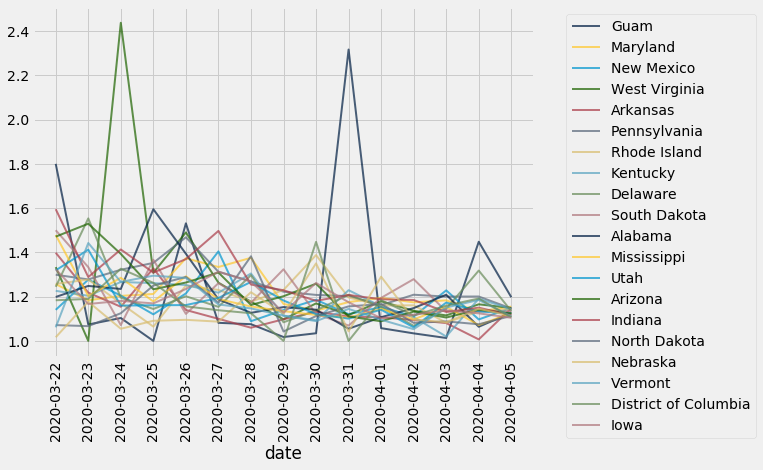

In [26]:
prior_to(get_rates(cases), 14).top(20).oplot(height=6, width=8)
_ = plots.xticks(rotation=90)

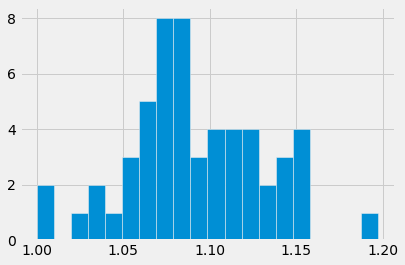

In [27]:
_ = plots.hist(get_rates(cases).take[-1].row(0)[1:], bins=20)

In [28]:
def best_rate(ts, n):
    rates = prior_to(get_rates(ts), 7).order_cols()
    best = rates.labels[-n:]
    return rates.extract(best)

In [29]:
best_rate(cases, 12)

date,Massachusetts,Washington,Montana,Hawaii,Georgia,Puerto Rico,Louisiana,Missouri,Maine,Idaho,Northern Mariana Islands,Virgin Islands
2020-03-29,1.16397,1.1357,1.09524,1.15894,1.09644,1.27,1.06787,1.07757,1.19905,1.18774,1,1.21053
2020-03-30,1.16085,1.0578,1.09938,1.16571,1.13008,1.37008,1.13701,1.16279,1.08696,1.33871,1,1.30435
2020-03-31,1.1509,1.02182,1.11864,1.09804,1.35785,1.37356,1.30112,1.28667,1.10182,1.26747,1,1
2020-04-01,1.16888,1.05593,1.09596,1.15179,1.15327,1.19665,1.22666,1.17024,1.13531,1.27186,3,1
2020-04-02,1.1587,1.17842,1.1106,1.0969,1.14659,1.1049,1.42435,1.16003,1.09302,1.33184,1.33333,1.23333
2020-04-03,1.16016,1.05786,1.08714,1.12014,1.09607,1.1962,1.12536,1.15213,1.14894,1.13692,1,1.02703
2020-04-04,1.12824,1.07637,1.07252,1.10095,1.06972,1.19577,1.21356,1.08424,1.05556,1.06318,1,1.10526
2020-04-05,1.0651,1.06482,1.0605,1.05731,1.05624,1.05088,1.04113,1.03317,1.0307,1.02228,1,1


In [30]:
def get_new(trend, region):
    return trend['new ' + region][-1]

def get_rate(trend, region):
    return trend['rate ' + region][-1]

def get_val(trend, region):
    return trend[region][-1]

def summary(ts, name, regions):
    trend = ts.trend()
    smry = Table().with_columns(
        name, regions,
        'current', [get_val(trend, r) for r in regions],
        'new',  [get_new(trend, r) for r in regions],
        'rate', [get_rate(trend, r) for r in regions]
    )
    return smry

In [31]:
case_sum = summary(cases, 'state', states)

In [32]:
case_sum

state,current,new,rate
Alabama,1841,208,1.12737
Alaska,185,16,1.09467
Arizona,2269,250,1.12382
Arkansas,853,110,1.14805
California,15076,1280,1.09278
Colorado,4950,376,1.0822
Connecticut,5675,399,1.07563
Delaware,673,80,1.13491
District of Columbia,998,96,1.10643
Florida,12342,805,1.06978


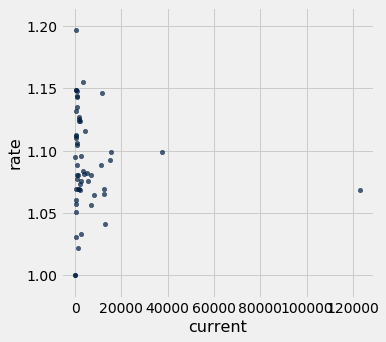

In [33]:
case_sum.scatter('current', 'rate')